In [109]:
import os; import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as ly
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

## Preprocessing data

In [9]:

def load_data(path):
    path = os.path.join(path)
    with open(path,'r') as f:
        data = f.read()
    return data.split("\n")

In [10]:
def process(x,y=False,length=None):
    token = Tokenizer(char_level=False)
    token.fit_on_texts(x)
    x_tokenized = token.texts_to_sequences(x)
    
    if length is None:
        length = max([len(sent) for sent in x_tokenized])
        
    padded =  pad_sequences(x_tokenized,maxlen=length,padding="post")
    
    if y==True:   ## For french set
        padded = padded.reshape(*padded.shape,1)
    return padded,token
    

In [53]:
def logits_to_text(logits,tokenizer):
    index_word = {id:word for word ,id in tokenizer.word_index.items()}
    index_word[0] = "<DONE>"
    return " ".join([index_word[pred]  for pred in np.argmax(logits,1)])

def token_to_words(sequences,tokenizer):
    index_word = {id:word for word,id in tokenizer.word_index.items()}
    index_word[0] = "<Done>"
    return [index_word[token] for token in sequences if index_word[token]!= "<Done>"]

In [12]:
def pad(x,length=None):
    if length is None:
        length =  max([len(sent)  for sent in x])
    padded = pad_sequences(x,maxlen=length,padding="post")
    return padded

In [14]:
english_sent = load_data("data/small_vocab_en.txt")
french_sent = load_data("data/small_vocab_fr.txt")

In [107]:
english_sent[0], french_sent[0]

('new jersey is sometimes quiet during autumn , and it is snowy in april .',
 "new jersey est parfois calme pendant l' automne , et il est neigeux en avril .")

In [16]:
(english_padded ,english_token)= process(english_sent)

In [17]:
(french_padded,french_token) =  process(french_sent,y=True)

## Model Building

In [24]:
def final_model(input_shape,output_seq_length,english_vocab,french_vocab):
    model = Sequential([
        ly.Embedding(input_dim=english_vocab,input_length=input_shape[1],output_dim=128),
        ly.Bidirectional(ly.GRU(256,return_sequences=False)),
        ly.RepeatVector(output_seq_length),
        ly.Bidirectional(ly.GRU(256,return_sequences=True)),
        ly.TimeDistributed(ly.Dense(french_vocab,activation="softmax"))
        
    ])
    model.compile(loss="sparse_categorical_crossentropy",optimizer=Adam(learning_rate=0.005),metrics=["acc"])
    return model 
    

In [108]:
tmp_x = pad(english_padded,french_padded.shape[1]).reshape((-1,french_padded.shape[-2])) ## Reshaping according to RNN model

In [26]:
tmp_x[0]

array([17, 23,  1,  8, 67,  4, 39,  7,  3,  1, 55,  2, 44,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32)

In [27]:
model = final_model(tmp_x.shape,french_padded.shape[1],len(english_token.word_index)+1,len(french_token.word_index)+1)

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
hist  = model.fit(tmp_x,french_padded,batch_size=1024,epochs=20,validation_split=0.2)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - acc: 0.4249 - loss: 3.0260 - val_acc: 0.6285 - val_loss: 1.4500
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - acc: 0.6671 - loss: 1.2533 - val_acc: 0.7720 - val_loss: 0.8157
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - acc: 0.8007 - loss: 0.7065 - val_acc: 0.8573 - val_loss: 0.4933
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - acc: 0.8853 - loss: 0.4065 - val_acc: 0.8333 - val_loss: 0.5285
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - acc: 0.8996 - loss: 0.3441 - val_acc: 0.9355 - val_loss: 0.2388
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - acc: 0.9409 - loss: 0.2115 - val_acc: 0.9422 - val_loss: 0.2099
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - acc: 0.9513 - loss: 0.1778 - val_acc: 0.9595 - val_loss: 0.1523
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - acc: 0.9612 - loss: 0.1430 - val_acc: 0.9511 - val_loss: 0.1734
Epoch 9/20
108/108 ━━━━━━━━━━━━━

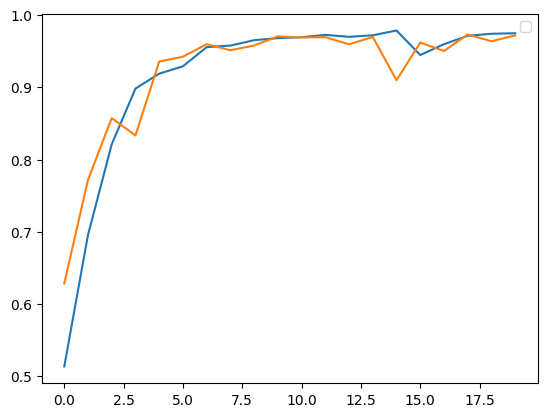

In [110]:
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])
plt.legend()

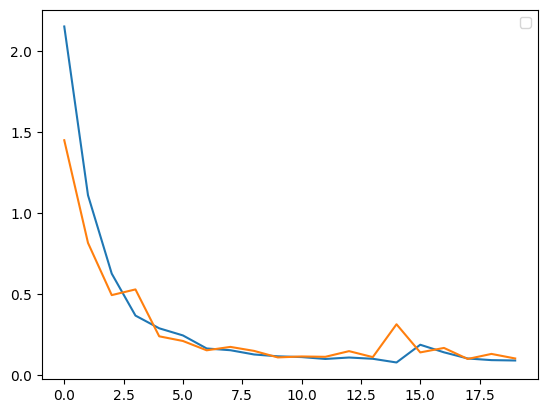

In [111]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend()

## Making Predictions 

In [58]:
" ".join(token_to_words(tmp_x[:1][0],english_token))

'new jersey is sometimes quiet during autumn and it is snowy in april'

In [112]:
logits_to_text(model.predict(tmp_x[:1])[0],french_token)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


"new jersey est parfois calme pendant l' automne et il neigeux neigeux en avril <DONE> <DONE> <DONE> <DONE> <DONE> <DONE> <DONE>"

In [101]:
y_id_to_word = {value: key for key, value in french_token.word_index.items()}
y_id_to_word[0] = '<PAD>'

In [79]:
def preprocess_text(text):
    sequence = [english_token.word_index[word] for word in text.split()]
    sequence = pad_sequences([sequence],maxlen=english_padded.shape[-1],padding="post")
    sequence = np.array([sequence[0],english_padded[0]])
    return sequence
    

In [103]:
def decode(predictions):
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))

In [113]:
sample  = "he saw a old yellow truck "
text  = preprocess_text(sample)

In [100]:
predictions   =  model.predict([text])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [104]:
 decode(predictions)

il a vu un vieux camion jaune <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
